# Demonstration Notebook
## Train model to recognize notes from input sounds

By Ben Walsh \
For Liloquy

&copy; 2021 Ben Walsh <ben@liloquy.io>

## Contents

1. [Import Libraries](#lib_import)
1. [Data Import](#data_import)
1. [Data Exploration](#data_explore)
1. [Data Augmentation](#data_aug)
1. [Feature Extraction](#feat_extract)
1. [Save Features](#feat_save)


TO DO
- Add column to database for train=1, test=0
- Generalize MUSIC_FPATH in piano_notes
- Generalize training functions to look for any files matching corresponding note tag
  - Add _Male2 recordings
- Submodule repo into simple_gui
- Define data_folder and import so hum_wav_file in test model can use it

In [2]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [3]:
import sys
import os
import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import pickle
import sqlite3

from scipy.io import wavfile as wav
from IPython.display import Audio

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.music_util import note_to_freq, add_noise, melody_transcribe, melody_write, Note
from util.ml_util import feat_extract, load_training_data


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_Db4.wav does not exist
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_Eb4.wav does not exist
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_Gb4.wav does not exist
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_Ab4.wav does not exist
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_Bb4.wav does not exist
C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_B4.wav does not exist


## <a id = "data_import"></a>2. Data Import

In [4]:
SCALE = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')
X, y, fs = load_training_data(SCALE)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:83: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [5]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(SCALE)))
print('X sample length is {}'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(SCALE)))

X is a <class 'numpy.ndarray'> with shape (6, 120000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 120000
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

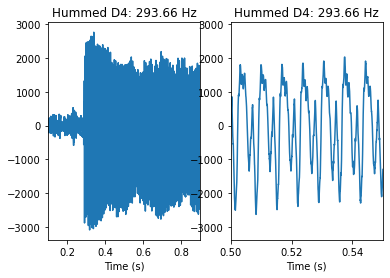

In [6]:
# Pick a note to plot
idx_test = 1
signal_test = X[idx_test,:]
note_test = SCALE[idx_test]

# Create array of time samples, converting number of samples and dividing by sample of frequency 
t_array = np.arange(X.shape[1])/fs

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

# Plot waveform over shorter time period to see sine
plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

plt.show()


### Plot Frequency

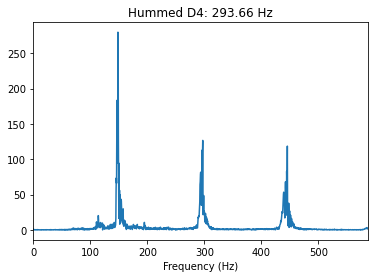

In [7]:
# Take FFT
ftransform = np.fft.fft(signal_test)/len(signal_test)
ftransform = ftransform[range(int(len(signal_test)/2))]
tp_count = len(signal_test)
vals = np.arange(tp_count/2)
t_period = tp_count/fs

# Scale to Hz frequency values for plotting
freqs = vals/t_period

plt.plot(freqs, abs(ftransform))
plt.xlim((0, 2*note_to_freq[note_test]))
plt.xlabel('Frequency (Hz)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.show()

## <a id = "data_aug"></a> 4. Data Augmentation 

### Synthesize larger dataset 
Add noise to original recordings

In [8]:
augment_factor = 10
aug_ampl = 100

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((augment_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((augment_factor*X.shape[0], 1)), columns=['note'])

# Add white noise to each element
for idx in range(X.shape[0]):
    for sample in range(augment_factor):
        X_aug[sample+augment_factor*idx,:] = add_noise(X[idx,:], ampl=aug_ampl)
        y_aug.iloc[sample+augment_factor*idx,0] = SCALE[idx]

Sanity check the dimensions of the augmented training set

In [9]:
print('X_aug has shape {}, with augment_factor = {}'.format(X_aug.shape, augment_factor))
print('Original X has shape {}'.format(X.shape))

X_aug has shape (60, 120000), with augment_factor = 10
Original X has shape (6, 120000)


### Plot example with added noise


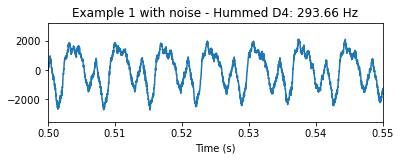

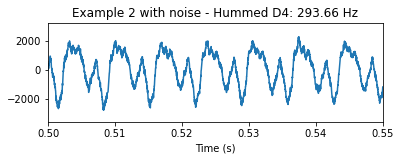

In [10]:
idx_test = 1
signal_test1 = X_aug[idx_test*augment_factor,:]
signal_test2 = X_aug[idx_test*augment_factor+1,:]
note_test = SCALE[idx_test]

# Plot waveform over shorter time period to see sine
plt.subplot(211)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 1 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test1)

plt.show()

plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 2 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [11]:
X_feat = feat_extract(X_aug, fs, note_to_freq, SCALE)

In [12]:
X_feat.head()

,C4,D4,E4,F4,G4,A4
0,0.281179,0.141380,0.138653,0.183823,0.215715,0.039251
1,0.283004,0.143437,0.137952,0.183288,0.209280,0.043040
2,0.283969,0.150634,0.136020,0.180691,0.214396,0.034291
3,0.285493,0.145472,0.135773,0.181049,0.214037,0.038177
4,0.284290,0.146579,0.132058,0.181963,0.214820,0.040290


### Explore extracted features

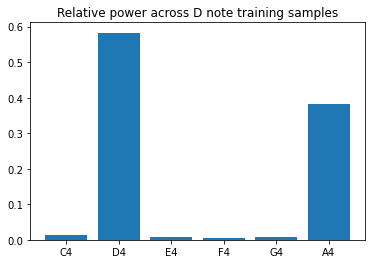

In [13]:
note_test = 'D'
plt.bar(SCALE, X_feat[y_aug['note'].str.contains(note_test)].mean())
plt.title('Relative power across {} note training samples'.format(note_test))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

In [30]:
FEAT_DB_NAME = 'features.db'
TABLE_NAME = 'X_all'
conn = sqlite3.connect(FEAT_DB_NAME)
c = conn.cursor()

# Create table
c.execute('''CREATE TABLE IF NOT EXISTS {}
             ({} real, {} real, {} real, 
             {} real, {} real, {} real)'''.format(TABLE_NAME, X_feat.columns[0],
                                                    X_feat.columns[1],
                                                 X_feat.columns[2],
                                                 X_feat.columns[3],
                                                 X_feat.columns[4],
                                                 X_feat.columns[5]))

# Commit the changes to db
conn.commit()

# Insert multiple records in a single query
c.executemany('INSERT INTO {} VALUES(?,?,?,?,?,?);'.format(TABLE_NAME), X_feat.values);
conn.commit()

# Close the connection
conn.close()

Split data for training and testing and save off features

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)

DATA_FOLDER = r"../data"

if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)

X_train_file = '../data/X_train.csv'
X_train.to_csv(X_train_file)

X_test.to_csv('../data/X_test.csv')

y_train_file = '../data/y_train.csv'
y_train.to_csv(y_train_file)
y_test.to_csv('../data/y_test.csv')